# 🚫⚠️ **CRITICAL WARNING** ⚠️🚫

## 🖥️ Do **NOT** run this on your PC  
### Unless you have **UNLIMITED** resources!


In [39]:
!pip install osmnx

In [40]:
import pandas as pd
import osmnx as ox
import networkx as nx
import random
import numpy as np
import heapq
import time
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
# do not show any warnings
import warnings
warnings.filterwarnings('ignore')

In [41]:
# —————— 1. Load & filter your station data ——————

cs_df = pd.read_csv(
    "los_angeles.csv"
)

In [42]:
import osmnx as ox
import networkx as nx
import numpy as np
import random

random.seed(10)
np.random.seed(10)

print("Loading road network...")

# Define a smaller region of Los Angeles (center point + buffer)
place = "Los Angeles, California, USA"
center_point = ox.geocode(place)
G = ox.graph_from_point(center_point, dist=1000, network_type='drive')  # 5km buffer
G_undirected = G.to_undirected()

# precompute node positions for plotting
node_gdf = ox.graph_to_gdfs(G, nodes=True, edges=False)
node_positions = {node: (data['x'], data['y']) for node, data in node_gdf.iterrows()}

print("Road network ready")

Loading road network...
Road network ready


In [43]:
# —————— 3. Snap stations to nearest graph nodes ——————

# Snap stations to the smaller graph G
station_nodes = ox.nearest_nodes(
    G,
    X=cs_df['Longitude'].values,
    Y=cs_df['Latitude'].values
)

# Optional: filter cs_df for valid snapped nodes (in case snapping fails or is out-of-bounds)
cs_df_filtered = cs_df[[node in G.nodes for node in station_nodes]]

# Filter station_nodes accordingly to keep alignment
station_nodes = [node for node in station_nodes if node in G.nodes]

# Build capacity dictionary
charging_capacity = {}
for node, (_, row) in zip(station_nodes, cs_df_filtered.iterrows()):
    cap = row['EV Level2 EVSE Num'] + row['EV DC Fast Count']
    charging_capacity[node] = max(1, int(cap))

# Track current usage (initially zero)
station_current_usage = {node: 0 for node in station_nodes}


In [44]:
# ─── 4. Pick start & goal ───

# Get list of nodes from the graph
nodes = list(G.nodes)
G_undirected = G.to_undirected()

# Randomly sample two nodes that are connected
start_node, goal_node = random.sample(nodes, 2)
while not nx.has_path(G_undirected, start_node, goal_node):
    start_node, goal_node = random.sample(nodes, 2)

print(f"Start: {start_node}, Goal: {goal_node}")


Start: 21748255, Goal: 3144543758


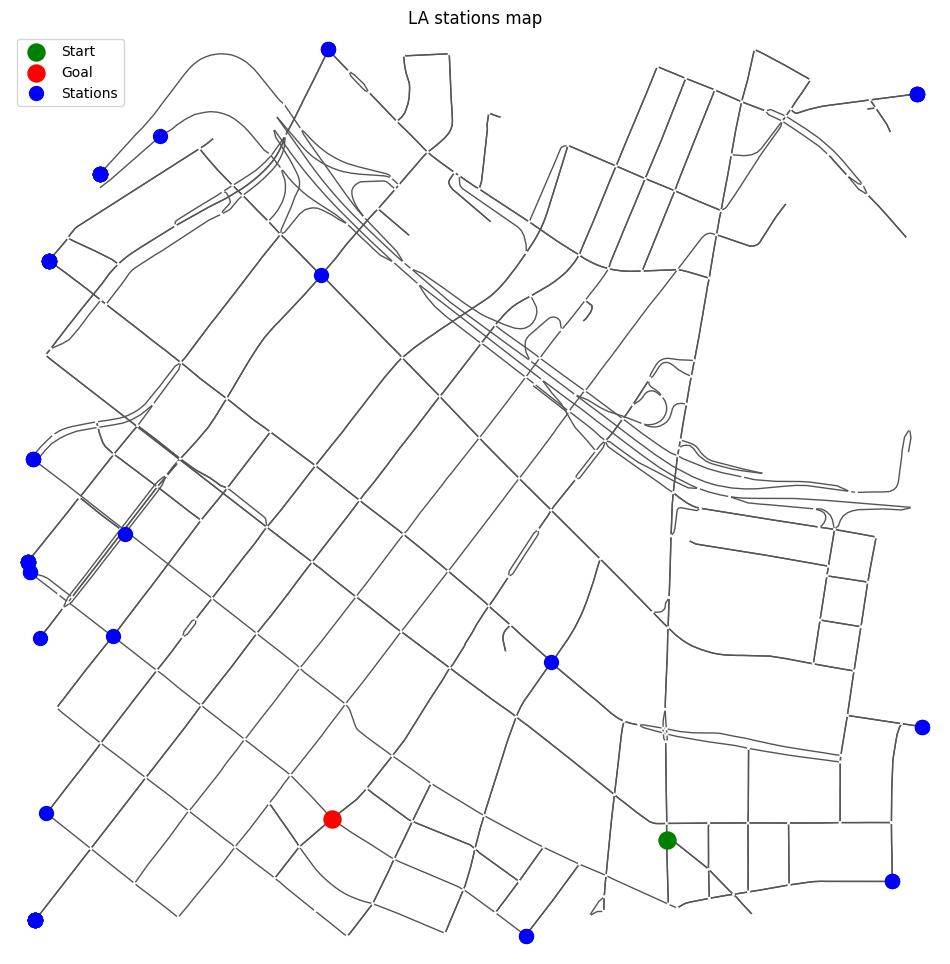

In [45]:
# —————— 5. Visualization functions ——————
def visualize_policy():
    fig, ax = plt.subplots(figsize=(12,12))
    ox.plot_graph(G, ax=ax, bgcolor='k', node_size=5, edge_color='#555555', show=False)


    nx.draw_networkx_nodes(G, pos=node_positions, nodelist=[start_node],
                           node_color='green', node_size=150, label='Start')
    nx.draw_networkx_nodes(G, pos=node_positions, nodelist=[goal_node],
                           node_color='red',   node_size=150, label='Goal')
    nx.draw_networkx_nodes(G, pos=node_positions, nodelist=station_nodes,
                           node_color='blue',  node_size=100, label='Stations')

    plt.title("LA stations map")
    plt.legend()
    plt.show()

# show the policy
visualize_policy()

In [46]:
# Calculate shortest path and length using the undirected graph
shortest_path = nx.shortest_path(G_undirected, source=start_node, target=goal_node, weight='length')
path_length = nx.shortest_path_length(G_undirected, source=start_node, target=goal_node, weight='length')

print(f"Shortest path length: {path_length:.2f} meters")
print("Path node sequence:", shortest_path)

Shortest path length: 1039.34 meters
Path node sequence: [21748255, 122954789, 25062070, 1790748722, 1790748726, 67619212, 1738803667, 69091937, 1738803668, 3144543758]


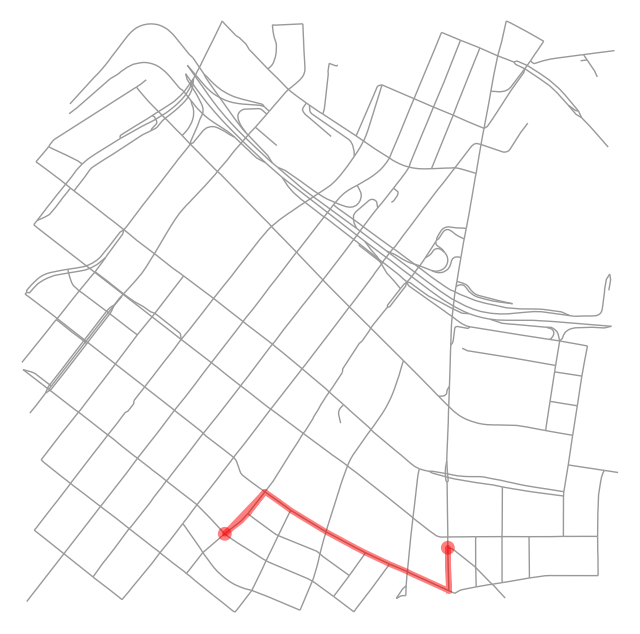

In [47]:
# Plot the shortest path on the map (use the same graph as for pathfinding)
fig, ax = ox.plot_graph_route(
    G_undirected,  # Use the undirected graph
    shortest_path,
    route_linewidth=4,
    node_size=0,
    bgcolor='white'
)

# Highlight start and goal nodes in red
start_node_pos = node_positions[start_node]
goal_node_pos = node_positions[goal_node]

# Plot the start and goal nodes
ax.scatter(*start_node_pos, color='blue', s=100, label="Start Node")
ax.scatter(*goal_node_pos, color='blue', s=100, label="Goal Node")

# Add a legend
ax.legend()

plt.show()

### 🚀 Algorithmic Solution Using DFS – Exponential Complexity Alert!

This solution explores **all possible paths** using **Depth-First Search (DFS)** to find the **shortest path**.  
🔍 **Time Complexity:** `O(2ⁿ)` — extremely inefficient for large graphs.  
💾 **Memory Usage (RAM):** also grows **exponentially** — storing recursive calls and visited states quickly overwhelms system memory.

> ⚠️ **Warning:** Do **not** attempt to run this on your local machine for large graphs!  
> For a graph with **300 nodes**, the estimated execution time is roughly **2 to 3 years**, and your system may run out of memory long before that ⏳.


In [48]:
from queue import PriorityQueue
import networkx as nx
# Assume G_undirected is your MultiGraph
# Assume charging_stations is a set or list of node IDs with chargers
visited = {}  # Dict to store visited states
all_paths = []  # To store all valid paths
all_battery_levels = []  # Corresponding battery levels for each path
all_distances = []  # Corresponding total distances for each path
# Dummy functions – replace with actual logic if needed
def distance_between(graph, u, v):
    """Compute the minimum length between u and v among all parallel edges."""
    try:
        edge_data = graph.get_edge_data(u, v)
        if edge_data:
            return min(d['length'] for d in edge_data.values())
        else:
            return float('inf')
    except:
        return float('inf')
def max_battery_func(node):
    if len(visited[node])>0 :
        return max(battery_level for _, battery_level in visited[node])
    return -1
def dfs_all_paths_battery_constraint(start_node, goal_node, efficiency, battery_start, path, battery_level_path, distance_driven, graph, max_battery):
    # Append current node to path and current battery level
    path.append(start_node)
    battery_level_path.append(battery_start)
    if start_node == goal_node:
        all_paths.append(list(path))  # Save copy
        all_battery_levels.append(list(battery_level_path))  # Save copy
        all_distances.append(distance_driven)
    else:
        if start_node in station_nodes:
            battery_level = max_battery
            path.append(start_node)
            battery_level_path.append(battery_level)
        else:
            battery_level = battery_start
        try:
            neighbors = sorted([(distance_between(graph, start_node, neighbor), neighbor) for neighbor in graph.neighbors(start_node)])
        except nx.NetworkXError:
            neighbors = []
            for dist,neighbor in neighbors:
                new_battery_level = battery_level - dist * efficiency
                new_distance_driven = distance_driven + dist
                if neighbor not in visited:
                    visited[neighbor] = []
                if (new_battery_level >= 0)and(new_battery_level>max_battery_func(neighbor)):
                        # Recursive call with copies of path and battery level list
                      visited[neighbor].append([new_battery_level,new_distance_driven])
                      dfs_all_paths_battery_constraint(
                          neighbor,
                          goal_node,
                          efficiency,
                          new_battery_level,
                          list(path),
                          list(battery_level_path),
                          new_distance_driven,
                          graph,
                          max_battery
                      )

### ⚡ Efficient Shortest Path Algorithm Using Priority Queue

This approach uses a **Priority Queue** (e.g., via a Min-Heap) to implement **Dijkstra’s Algorithm**, which efficiently finds the shortest path in a graph with non-negative edge weights.

🔍 **Time Complexity:** `O((V + E) log V)`  
Where:
- `V` = number of vertices (nodes)  
- `E` = number of edges

> ✅ Suitable for large graphs – can handle **thousands of nodes** in seconds on a standard machine.

In [49]:
# 1. Battery-aware shortest path using precomputed neighbors
def shortest_path_with_battery(G, sorted_neighbors, start_node, goal_node, battery_start, battery_max, efficiency, charging_nodes):
    priority_queue = []
    visited_heaps = {start_node: [(0, battery_start)]}
    heapq.heappush(priority_queue, (0, -battery_start, start_node, [],[]))  # (total_dist, -battery, current_node, path_so_far)
    while priority_queue:
        total_dist, neg_battery, node, path ,battery_evolution = heapq.heappop(priority_queue)
        battery = -neg_battery
        path = path + [node]
        battery_evolution = battery_evolution + [battery]
        if node == goal_node :
            return path, total_dist ,battery_evolution
        for distance, neighbor in sorted_neighbors.get(node, []):
            battery_after = battery - distance * efficiency
            if battery_after >= 0:
                new_total_dist = total_dist + distance
                if neighbor not in visited_heaps:
                    visited_heaps[neighbor] = []
                    if neighbor in charging_nodes:
                        path = path + [neighbor]
                        battery_evolution = battery_evolution + [battery_after]
                        visited_heaps[neighbor].append((new_total_dist , battery_max))
                        heapq.heappush(priority_queue, (new_total_dist, -battery_max, neighbor, path, battery_evolution))
                    else:
                        visited_heaps[neighbor].append((new_total_dist , battery_after))
                        heapq.heappush(priority_queue, (new_total_dist, -battery_after, neighbor, path, battery_evolution))
                else :
                    state_neighbor =visited_heaps[neighbor]
                    # print(state_neighbor)
                    if (battery_after > state_neighbor[-1][1]) :
                        if neighbor not in charging_nodes:
                            heapq.heappush(priority_queue, (new_total_dist, -battery_after, neighbor, path, battery_evolution))


    return None, float('inf') , None

In [50]:
# 2. Precompute sorted neighbors for all nodes
def get_sorted_neighbors(G):
    sorted_neighbors = {}
    for node in G.nodes:
        neighbors = []
        for neighbor in G.neighbors(node):
            edge_data = G[node][neighbor][0]
            dist = edge_data.get('length', 1)
            neighbors.append((dist, neighbor))
        sorted_neighbors[node] = sorted(neighbors)  # sort by increasing distance
    return sorted_neighbors

In [51]:
sorted_neighbors = get_sorted_neighbors(G_undirected)

# Compute path
path, total_distance , battery_evolution = shortest_path_with_battery(
    G=G_undirected,
    sorted_neighbors=sorted_neighbors,
    start_node=start_node,
    goal_node=goal_node,
    battery_start=1000,
    battery_max=1000,
    efficiency=1.5,  # battery units per meter
    charging_nodes=station_nodes
)

print("Path:", path )
print("Total Distance:", total_distance)
print("start_node : ",start_node)
print("goal_node : " , goal_node)
print("battery_evolution : ",battery_evolution)
 # print("charging nodes " , station_nodes)

Path: [21748255, 122954789, 25062070, 1790748722, 122620342, 122620342, 1790748724, 1837231040, 1903989455, 3144543758]
Total Distance: 1067.913329641333
start_node :  21748255
goal_node :  3144543758
battery_evolution :  [1000, np.float64(784.2046644232536), np.float64(555.3293673484965), np.float64(457.82835228956844), np.float64(159.03261143618363), 1000, np.float64(872.0259616295986), np.float64(740.2689287853228), np.float64(486.7796188669654), np.float64(239.09739410181683)]


In [52]:
import heapq

heap = []
heapq.heappush(heap, (1, "task1"))
heapq.heappush(heap, (2, "task2"))

item = heapq.heappop(heap)
print(item)  # (1, 'task1')
print("heap" , heap)

(1, 'task1')
heap [(2, 'task2')]


In [53]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

# —————— 5. Visualization function ——————
def visualize_path_with_battery(G, node_positions, path, start_node, goal_node, station_nodes, battery_evolution):
    fig, ax = plt.subplots(figsize=(12, 12))
    ox.plot_graph(G, ax=ax, bgcolor='k', node_size=5, edge_color='#555555', show=False)

    # Draw start, goal, and station nodes
    nx.draw_networkx_nodes(G, pos=node_positions, nodelist=[start_node],
                           node_color='green', node_size=150, label='Start')
    nx.draw_networkx_nodes(G, pos=node_positions, nodelist=[goal_node],
                           node_color='red', node_size=150, label='Goal')
    nx.draw_networkx_nodes(G, pos=node_positions, nodelist=station_nodes,
                           node_color='blue', node_size=100, label='Stations')

    # Draw path
    if path:
        path_edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_nodes(G, pos=node_positions, nodelist=path,
                               node_color='yellow', node_size=30)
        nx.draw_networkx_edges(G, pos=node_positions, edgelist=path_edges,
                               edge_color='yellow', width=2)

        # Annotate battery levels
        for i, node in enumerate(path):
            plt.text(*node_positions[node], f"{battery_evolution[i]}", fontsize=8,
                     color='white', ha='center', va='center')

    plt.title("Shortest Path with Battery Constraints")
    plt.legend()
    plt.show()


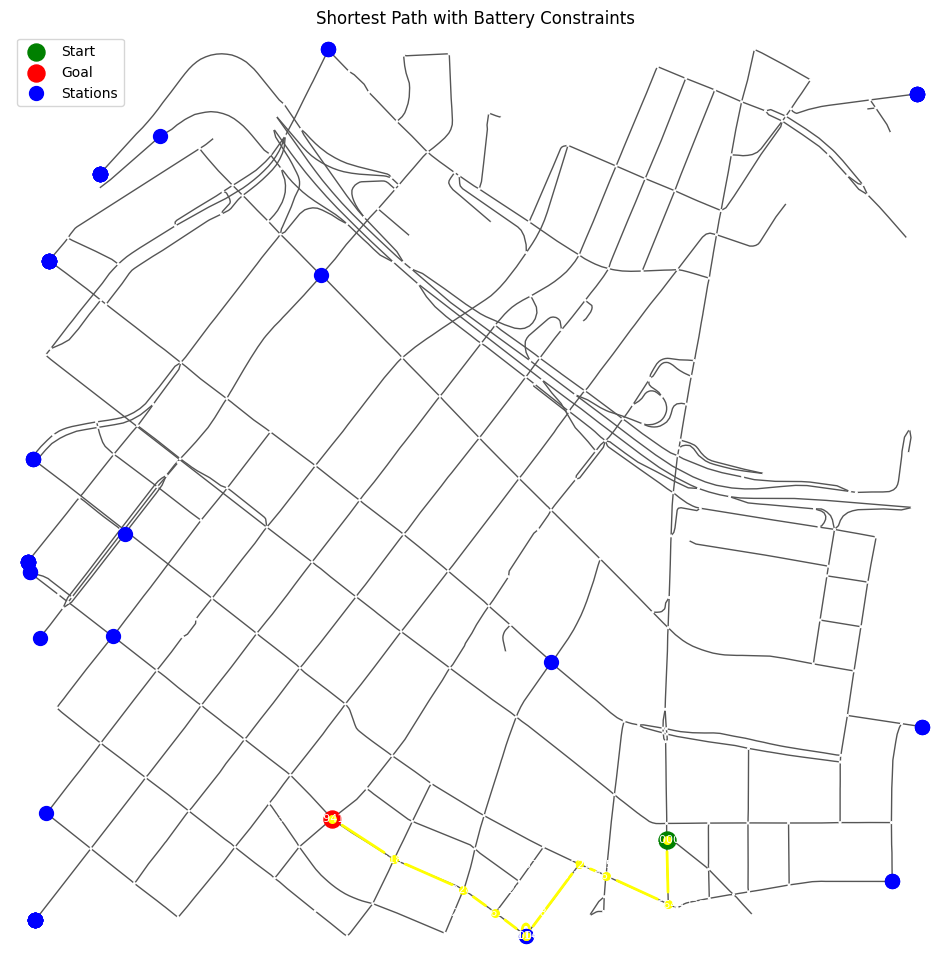

In [54]:
# —————— Call the visualization ——————
visualize_path_with_battery(
    G=G_undirected,
    node_positions=node_positions,  # Make sure this is a dict {node: (x, y)}
    path=path,
    start_node=start_node,
    goal_node=goal_node,
    station_nodes=station_nodes,
    battery_evolution=battery_evolution
)

In [55]:
import matplotlib.pyplot as plt

def plot_battery_evolution(path, battery_evolution):
    plt.figure(figsize=(12, 6))
    x=[]
    j=0
    for i  in range(len(path)-1) :
        x.append(j)
        if (path[i] != path[i+1]) :
            j += 1
    if (path[-2]!=path[-1]) :
        x.append(j+1)
    else :
        x.append(j)
    plt.plot(x, battery_evolution, marker='o')
    plt.xticks(rotation=45)
    plt.xlabel("Step in Path")
    plt.ylabel("Battery Level")
    plt.title("Battery Evolution Along the Path")


    plt.tight_layout()
    plt.grid(True)
    plt.show()

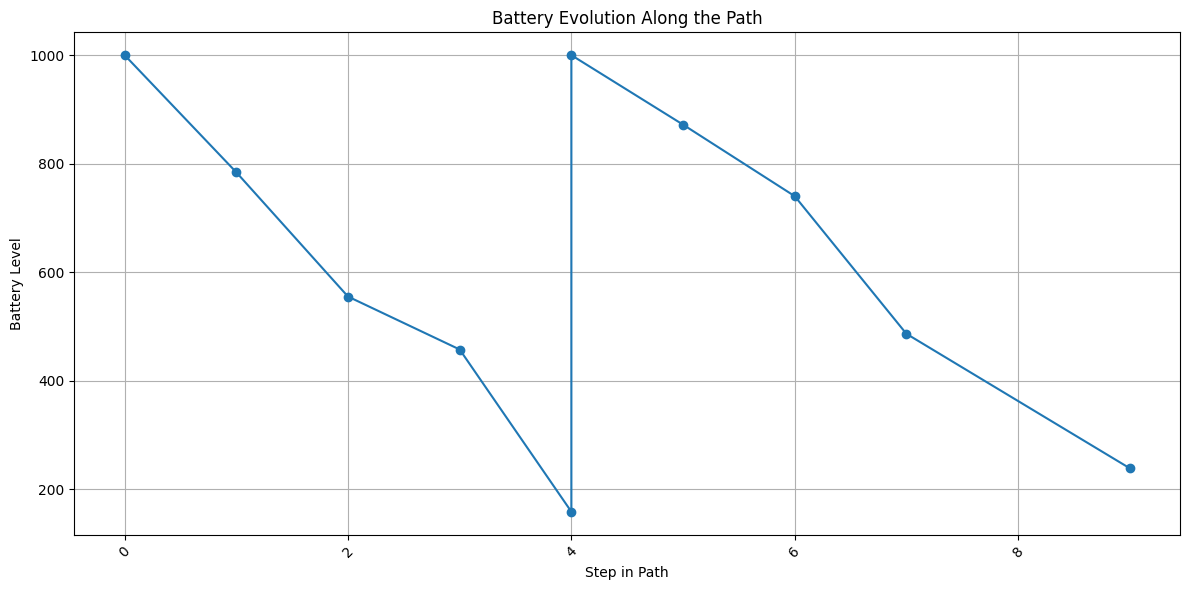

In [56]:
plot_battery_evolution(path, battery_evolution)